In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from model import OrigamiNetwork

# Square

In [2]:
# layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

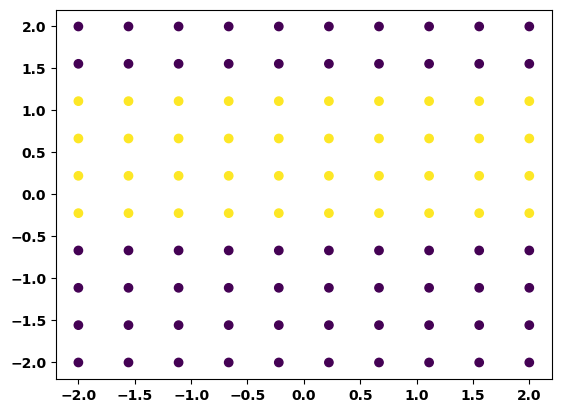

In [3]:
fv1 = np.array([0,.5])
size = 10

# make a meshgrid of x and y values
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
out1 = layer_sam(pairs, fv1)
Y = out1[:,1] > -.5
plt.scatter(pairs[:,0], pairs[:,1], c=Y)

In [4]:
# fv1 = .5*np.array([0,.5])
# size = 10

# # make a meshgrid of x and y values
# x1 = np.linspace(-2,2,size)
# x2 = np.linspace(-2,2,size)
# X1,X2 = np.meshgrid(x1,x2)

# # reshape the meshgrid into a 2D array and concatenate them
# X1 = X1.reshape(-1,1)
# X2 = X2.reshape(-1,1)
# pairs = np.concatenate((X1,X2),axis=1)

# # Define how many rows from the top and bottom should be 1s
# top_bottom_rows = 2  # Adjust this value for more or fewer rows

# # Generate the mask for top and bottom rows
# def create_row_mask(size, top_bottom_rows):
#     mask = np.zeros((size*size,), dtype=bool)
#     for i in range(top_bottom_rows):
#         mask[i*size:(i+1)*size] = True  # Top rows
#         mask[-(i+1)*size:-i*size if i != 0 else None] = True  # Bottom rows
#     return mask

# # Update the layer function to apply transformation only for selected rows
# def layer(D, n, row_mask):
#     scales = (D @ n) / np.dot(n, n)
#     projected = 2 * np.outer(scales, n)
#     adjustment = 2 * n - projected
#     # Apply adjustment only to rows in top and bottom based on mask
#     return D + row_mask[:, np.newaxis] * adjustment

# row_mask = create_row_mask(size, top_bottom_rows)

# # Apply the layers
# cut1 = layer(pairs, fv1, row_mask)
# cut2 = layer(cut1, fv2, row_mask)
# cut = layer(cut2, fv3, row_mask)

# Y = cut[:,1] > .9
# # plt.scatter(pairs[:,0], pairs[:,1], c=Y)

# # plot pairs
# plt.scatter(pairs[:,0], pairs[:,1], c=Y)
# plt.show()


In [5]:
# make an array of 20 points -2 to 2
count = 20
pairs1d = np.linspace(-2,2,count)
# 0-5 are 1, 15-20 are 1
y1d = np.zeros(count)
y1d[:6] = 1
y1d[-6:] = 1
pairs1d = np.expand_dims(y1d, axis=1)

In [28]:
score = 0.5
while score == 0.5:
    test = OrigamiNetwork(layers=1, width=None, epochs=100, learning_rate=0.01, optimizer="grad", reg=0, leak=0.2)
    # test.output_layer = np.array([[ 0 , 1],
    #                             [ 0, 0]])
    # test.b = np.array([0.0, 0])
    # folds, cut, score = test.beam_search(pairs, Y, max_depth=10, beam_width=6, iter=100)
    # score = test.score()
    # print(score, "before training")
    # test.fold_vectors = np.array([[0, .5]])
    histories = test.fit(pairs, Y, freeze_cut=False, freeze_folds=False)
    out = test.forward_pass(pairs)
    score = test.score()
    print(score, "after training")
    break
print(test.output_layer)
print(test.b)

Epoch 100/100: 100%|██████████| 100/100 [00:00<00:00, 465.11it/s]

0.5 after training
[[-0.70513573 -1.58868266]
 [ 0.01047804 -1.00826855]]
[0.00928074 0.86573398]


In [10]:
# test.fold_vectors = np.array([[0, -1],
#                              [1.5, 0],
#                              [0, -0.5], 
#                              [1.2, 0],
#                              [0.45, 0.4],
#                              [-0.36, 0.26]])
# test.layers = len(test.fold_vectors)
# out = test.forward_pass(pairs)
# test.fit(freeze_folds=True, maxiter=100)

Plotting: 100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


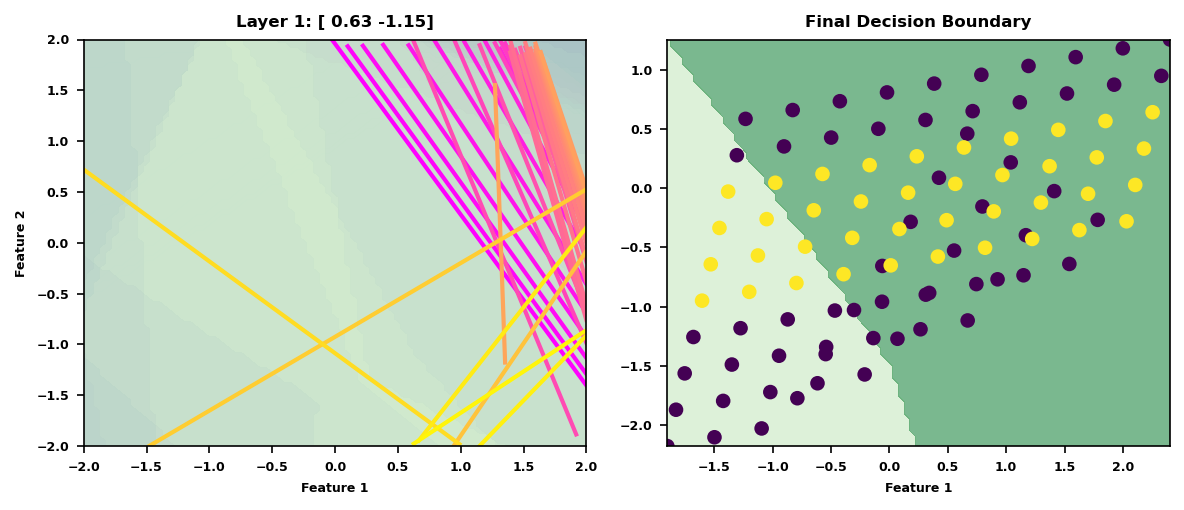

[[-0.70513573 -1.58868266]
 [ 0.01047804 -1.00826855]]
[0.00928074 0.86573398]


In [29]:
include_cut = True
n_folds = 50
X, Y = None, None
resolution = 0.05
import copy
# import make subplots
from plotly.subplots import make_subplots


def draw_fold( hyperplane, outx, outy, color, name):
    """
    This function draws a hyperplane on a plot
    
    Parameters:
        hyperplane (list) - The hyperplane to draw
        outx (list) - The x values of the data
        outy (list) - The y values of the data
        color (str) - The color of the hyperplane
        name (str) - The name of the hyperplane
    """
    plane_domain = np.linspace(np.min(outx), np.max(outx), 100)
    if hyperplane[1] == 0:
        plt.plot([hyperplane[0], hyperplane[0]], [np.min(outy), np.max(outy)], color=color, lw=2, label=name)
    elif hyperplane[0] == 0:
        plt.plot([np.min(outx), np.max(outx)], [hyperplane[1], hyperplane[1]], color=color, lw=2, label=name)
    else:
        a, b = hyperplane
        slope = -a / b
        intercept = b - slope * a
        plane_range = slope * plane_domain + intercept
        # set values outside y range to NaN
        plane_range = np.where((plane_range > np.min(outy)) & (plane_range < np.max(outy)), plane_range, np.nan)
        plt.plot(plane_domain, plane_range, color=color, lw=2, label=name)

# initialize input
X = test.X if X is None else X
Y = test.y if Y is None else Y
mod_number = max(1, test.epochs // n_folds)
scalor = 1 / (30 * test.epochs / mod_number)

# get pure colors for color scale
length = 255
cmap = [plt.get_cmap('spring')(i) for i in range(0, length, length//n_folds)]
cmap = np.array([np.array(cmap[i][:-1])*length for i in range(n_folds)], dtype=int)
colors = ['#%02x%02x%02x' % tuple(cmap[i]) for i in range(n_folds)]

# set up grid
if include_cut:
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                        np.arange(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    og_output_layer = copy.deepcopy(test.output_layer)
    og_b_thing = copy.deepcopy(test.b)
    

# loop over each fold
out = test.forward_pass(X)
plt.figure(figsize=(8, 3.5*test.layers), dpi=150)
n_cols = 2
n_rows = test.layers // n_cols + 1
for i in range(test.layers):
    outx = out[i][:,0]
    outy = out[i][:,1]
    progress = tqdm(total=n_folds, desc="Plotting")
    
    # plot every mod_number fold and decision boundary
    plt.subplot(n_rows, n_cols, i+1)
    for j in range(0, len(test.fold_history), mod_number):
        idx = j//mod_number
        draw_fold(test.fold_history[j][i], outx, outy, color=colors[idx], name=None)
        if include_cut:
            test.output_layer = test.cut_history[j][0]
            test.b = test.cut_history[j][1]
            Z = test.predict(grid_points)
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=scalor*idx, cmap=plt.cm.YlGnBu)   
        progress.update(1)
    plt.ylim(np.min(outy), np.max(outy))
    plt.xlim(np.min(outx), np.max(outx)) 
    plt.tick_params(axis='both', which='major', labelsize=6)
    hyperplane = np.round(test.fold_vectors[i], 2)
    plt.title(f"Layer {i+1}: {hyperplane}", fontsize=8)
    if i % n_cols == 0:
        plt.ylabel("Feature 2", fontsize=6)
    if i >= n_cols * (n_rows - 1):
        plt.xlabel("Feature 1", fontsize=6)
    progress.close()

# reset the output layer and b
test.output_layer = og_output_layer.copy()
test.b = og_b_thing.copy()

# plot the final decision boundary
plt.subplot(n_rows, n_cols, n_rows*n_cols)
if include_cut:
    Z = test.predict(grid_points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Greens)
# plot the points
outx = out[-2][:,0]
outy = out[-2][:,1]
rescale = 1
plt.scatter(outx, outy, c=Y)
plt.ylim(rescale*np.min(outy), rescale*np.max(outy))
plt.xlim(rescale*np.min(outx), rescale*np.max(outx))
plt.xlabel("Feature 1", fontsize=6)
plt.title("Final Decision Boundary", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.show()

print(test.output_layer)
print(test.b)

In [55]:
test.output_layer = np.array([[ 0.2 , -0.8],
                              [ 0.3, 0.3]])
test.b = np.array([0.0, 0.77918789])

Plotting: 100%|██████████| 50/50 [00:04<00:00, 11.64it/s]


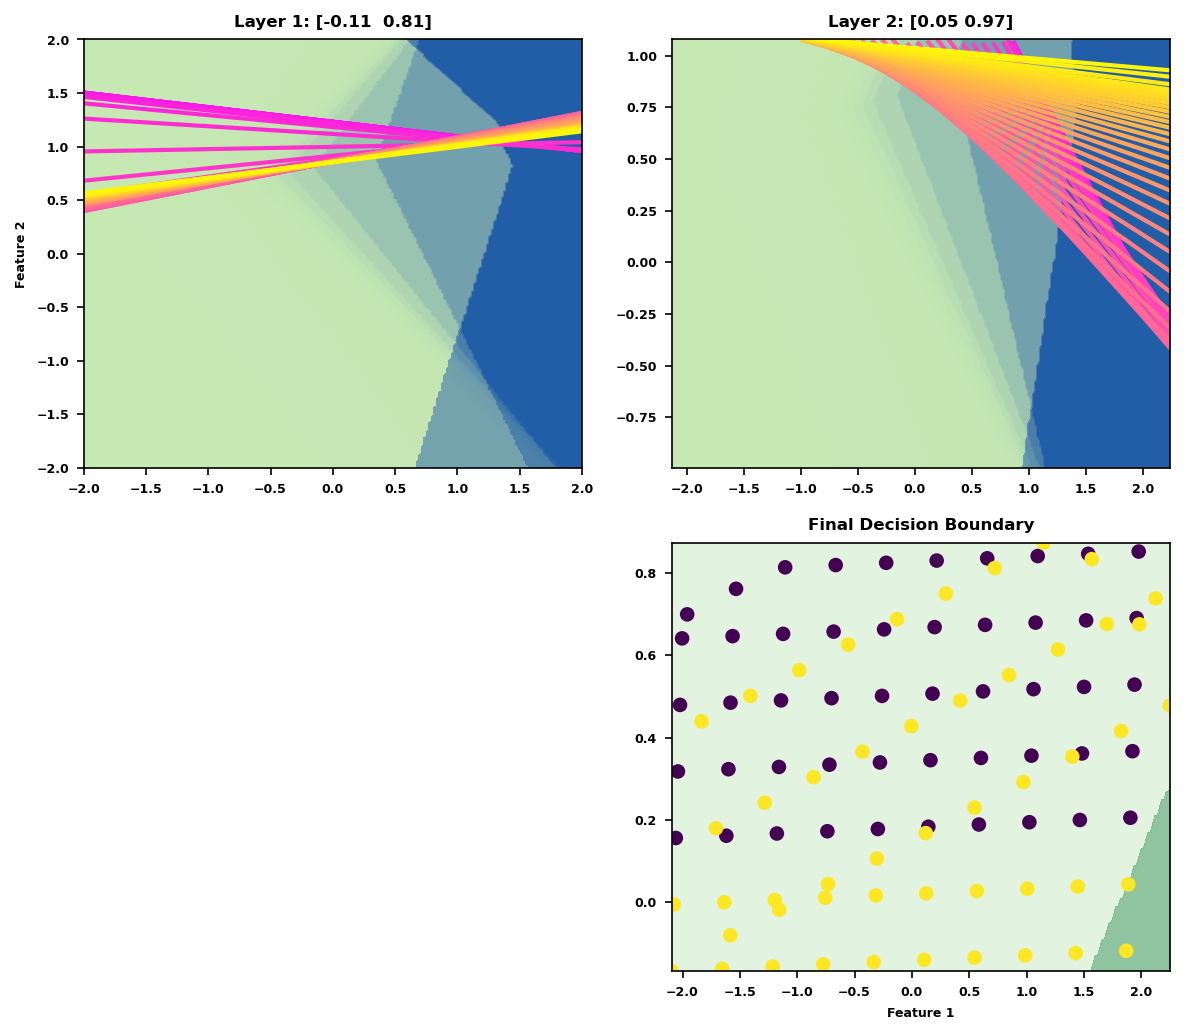

In [13]:
preds = test.predict(pairs)

test.plot_history(n_folds=50)

# print(test.score())
# plt.scatter(out[-2][:,0], out[-2][:,1], c=preds)
# plt.show()
# plt.scatter(out[-2][:,0], out[-2][:,1], c=Y)
# plt.show()

In [20]:
cmap = plt.get_cmap('spring')
# cmap = [cmap(i) for i in range(50)]
# cmap = np.array([np.array(cmap[i][1:])*255 for i in range(50)], dtype=int)
# cmap = ['#%02x%02x%02x' % tuple(cmap[i]) for i in range(50)]
count = 0
clr = (1.0, 0.0, 1.0, 1.0)
while clr != (1.0, 1.0, 0.0, 1.0):
    clr = cmap(count)
    count += 1
    # print(clr)
print(count)

256


In [8]:
max_score, best_folds = test.iscore_landscape(score_layers=None, create_plot=True, density=31, verbose=1, learning=False)

score Layer 0: 100%|██████████| 961/961 [00:10<00:00, 88.91it/s]


In [22]:
# count = 10
# progress = tqdm(total=count, desc="Training via Grid Search")
# for i in range(count):
#     show = i == count-1
#     max_score, best_folds = test.iscore_landscape(score_layers=None, create_plot=show, density=20, verbose=0, learning=True)
#     max_max_score = max(max_score)
#     progress.set_postfix({"max": max})
#     progress.update(1)
#     if max_score[-1] >= 0.98:
#         break
# progress.close()
# out = test.forward_pass(pairs)

Epoch 100/1000: 100%|██████████| 100/100 [00:00<00:00, 432.90it/s]


0.5


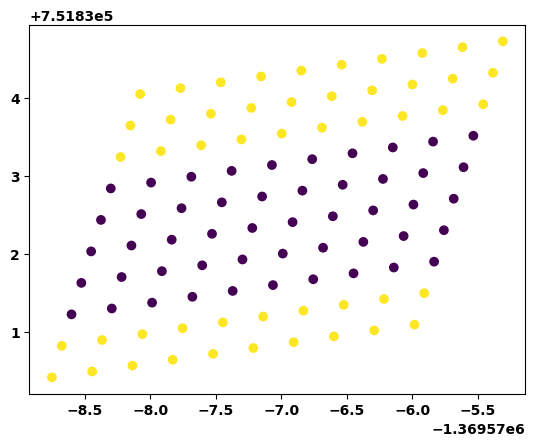

In [23]:
test.fit(freeze_folds=True, epochs=100)
print(test.score())
out = test.forward_pass(pairs)
plt.scatter(out[-2][:,0], out[-2][:,1], c=Y)

Plotting:  40%|████      | 20/50 [00:06<00:10,  2.89it/s]

i: 0, j: 400
fold_history: 1000
fold_history[j]: 1
j//50: 8
colors: 50


ValueError: 

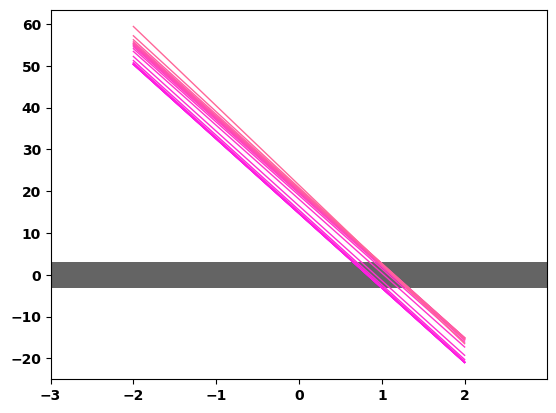

In [24]:
import copy 

def draw_fold(hyperplane, color):
    if hyperplane[1] == 0:
        # draw a vertical line
        plt.plot([hyperplane[0], hyperplane[0]], [np.min(outy), np.max(outy)], color=color, lw=1)
    elif hyperplane[0] == 0:
        # draw a horizontal line
        plt.plot([np.min(outx), np.max(outx)], [hyperplane[1], hyperplane[1]], color=color, lw=1)
    else:
        a, b = hyperplane
        slope = -a / b
        intercept = b - slope * a
        plane_range = slope * plane_domain + intercept
        plt.plot(plane_domain, plane_range, color=color, lw=1)


n_colors = 50
mod_number = len(test.fold_history) // n_colors
cmap = plt.get_cmap('spring')
colors = [cmap(i / n_colors) for i in range(n_colors)]

X = test.X
resolution = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                    np.arange(y_min, y_max, resolution))
grid_points = np.c_[xx.ravel(), yy.ravel()]
og_output_layer = copy.deepcopy(test.output_layer)
og_b_thing = copy.deepcopy(test.b)
scalor = 1 / (2 * len(test.fold_history) / mod_number)


out = test.forward_pass(pairs)
for i in range(len(out)-1):
    outx = out[i][:,0]
    outy = out[i][:,1]
    
    if i < len(test.fold_vectors):
        progress = tqdm(total=n_colors, desc="Plotting")
        hyperplane = test.fold_vectors[i]
        plane_domain = np.linspace(np.min(outx), np.max(outx), 100)
        for j in range(len(test.fold_history)):
            if j % mod_number == 0:
                try:
                    draw_fold(test.fold_history[j][i], color=colors[j//mod_number])
                    test.output_layer = test.cut_history[j][0]
                    test.b = test.cut_history[j][1]
                    Z = test.predict(grid_points)
                    Z = Z.reshape(xx.shape)
                    plt.contourf(xx, yy, Z, alpha=scalor*(j//mod_number), cmap=plt.cm.Greys)
                    progress.update(1)
                except:
                    # print all relevant information with labels
                    print(f"i: {i}, j: {j}")
                    print(f"fold_history: {len(test.fold_history)}")
                    print(f"fold_history[j]: {len(test.fold_history[j])}")
                    print(f"j//50: {j//50}")
                    print(f"colors: {len(colors)}")
                    raise ValueError
        progress.close()
    else:
        print("huh.", i, ">=", len(test.fold_vectors))

    plt.scatter(outx, outy, c=Y)
    test.output_layer = og_output_layer.copy()
    test.b = og_b_thing.copy()
    Z = test.predict(grid_points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Greys)
    plt.ylim(np.min(outy), np.max(outy))
    plt.xlim(np.min(outx), np.max(outx))
    plt.title(f"Layer {i+1}: {hyperplane}")
    plt.show()

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

# Simple 3x3

In [11]:
np.array([[1,2,3],[4,5,6],[7,8,9]])[np.array([0,2,2])]

array([[1, 2, 3],
       [7, 8, 9],
       [7, 8, 9]])

In [12]:
# Test case
Z = np.array([[1, 2, 3], [4, 5, 6]])
n = np.array([1, -1/2, 1])
width = len(n)

def derivative_fold(Z, n):
    # Get the scaled inner product, mask, and make the identity stack
    n_normal = n / np.dot(n,n)
    scales = Z@n_normal
    mask = scales > 1
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    
    # Calculate the first component and a helper term
    first_component = (1 - scales[:,np.newaxis, np.newaxis]) * identity_stack
    helper = 2*Z @ n_normal
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(helper, n_normal) - Z
    second_component = np.einsum('ij,k->ikj', outer_product, n_normal)
    
    # Return the derivative
    return 2 * mask[:,np.newaxis, np.newaxis] * (first_component + second_component)


result = derivative_fold(Z, n)
print(result)


[[[-0.50205761 -2.30452675 -1.61316872]
  [-0.08230453  0.48559671  0.80658436]
  [ 0.16460905 -2.30452675 -2.27983539]]

 [[-5.58847737 -5.76131687 -2.69958848]
  [ 0.46090535 -1.78600823  1.34979424]
  [-0.9218107  -5.76131687 -7.36625514]]]


In [13]:
x = np.array([1,2,3])
n = np.array([1,-1/2,1])
n_normal = n / np.dot(n,n)

first_comp = np.eye(3)*(1 - x@n_normal)

helper = 2*(x@n_normal)
inner = helper * n_normal - x
second_comp = np.outer(n_normal, inner)
print(2*(first_comp + second_comp))

[[-0.50205761 -2.30452675 -1.61316872]
 [-0.08230453  0.48559671  0.80658436]
 [ 0.16460905 -2.30452675 -2.27983539]]


# Circle

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 863.00it/s]


[[ 0.07270046 -1.22107325]
 [ 0.20737582  0.0956546 ]
 [-0.49139275  0.17124089]
 [-0.85605663  0.69640842]]


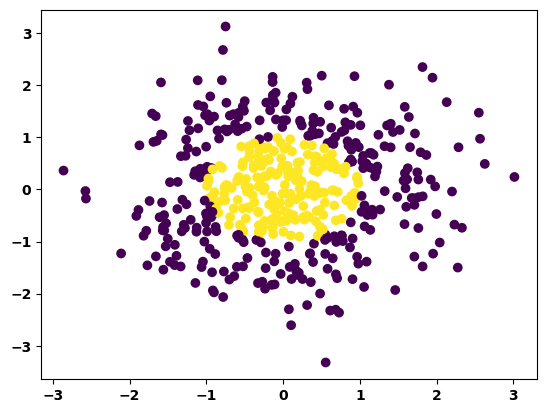

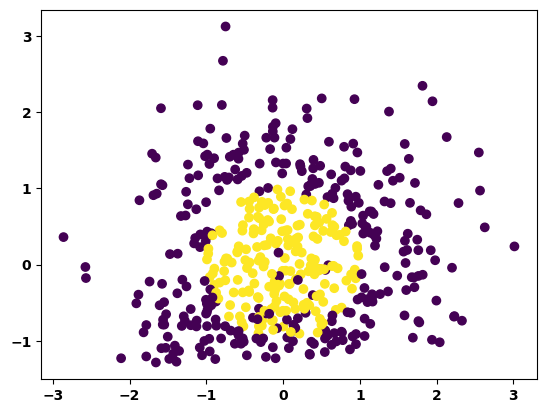

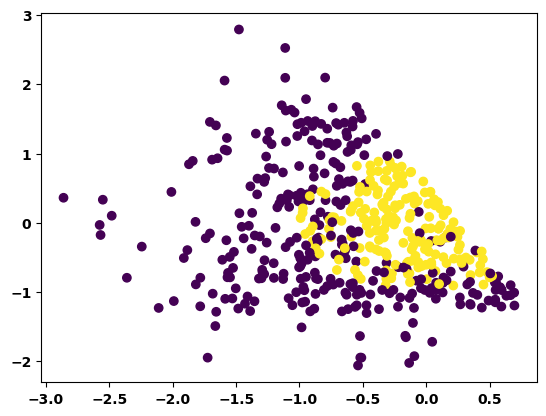

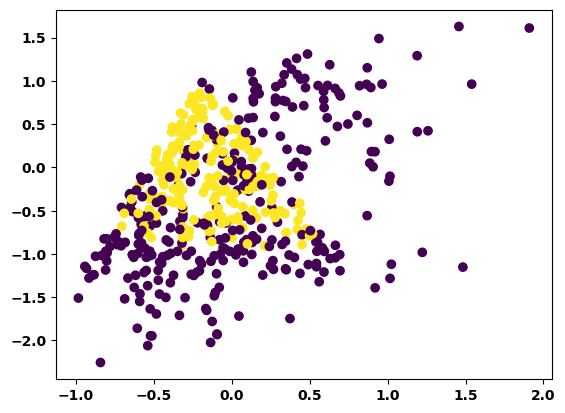

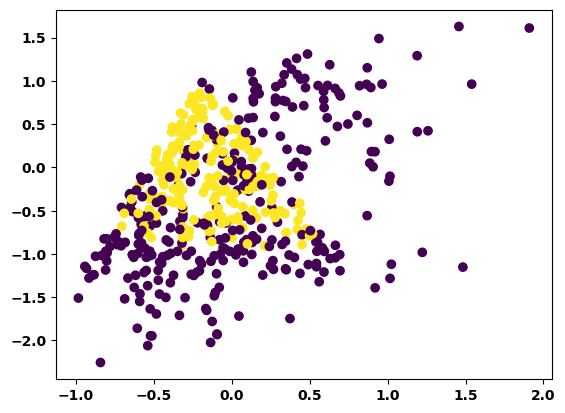

In [14]:
# Set up the model
layers = 4
width = 2
model = OrigamiNetwork(layers=layers, max_iter=1000, learning_rate=0.001)

# Create some dummy data
X = np.random.randn(500, width)
y = np.linalg.norm(X, axis=1) < 1

# # plot the data
# plt.scatter(X[:,0], X[:,1], c=y)
# plt.show()

# Set model parameters
model.fit(X, y)
print(model.fold_vectors)


out = model.forward_pass(X)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = y)
    plt.show()
    

In [15]:
y_hat = model.predict(X)

from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_hat))

0.68


# Digits

In [16]:
# import small digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=3, max_iter=100, learning_rate=0.001)
model.fit(X_train, y_train)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))

Training Progress: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]

0.7972222222222223


# OMSCS AI Challenge Question 2

In [17]:
def word_score(input, target):
    input = input.lower()
    target = target.lower()
    score = 0
    for i in range(len(input)):
        if input[i] == target[i]:
            score += 2
        elif input[i] in target:
            score += 1
    return score

target = 'sight'
inputs = [['state', 'scout', 'pilot', 'ghost'],
          ['spark', 'stark', 'stilt', 'stair'],
          ['might', 'tight', 'light', 'sight'],
          ['float', 'stoat', 'stilt', 'sight']]

for sequence in inputs:
    for word in sequence:
        print(word, word_score(word, target), end=' -> ')
    print()

state 4 -> scout 4 -> pilot 4 -> ghost 5 -> 
spark 2 -> stark 3 -> stilt 6 -> stair 4 -> 
might 8 -> tight 9 -> light 8 -> sight 10 -> 
float 2 -> stoat 5 -> stilt 6 -> sight 10 -> 


In [18]:
inputs = [['dflkz', 'skgkt', 'xetxt', 'fnyns', 'eihgd'],
          ['ypenb', 'ecbez', 'hqmnm', 'tskzh', 'sembt'],
          ['btpig', 'riuvq', 'fvght', 'sgprt', 'dujht']]

target = 'sight'
for sequence in inputs:
    for word in sequence:
        print(word, word_score(word, target), end=' - ')
    print()

dflkz 0 - skgkt 6 - xetxt 3 - fnyns 1 - eihgd 4 - 
ypenb 0 - ecbez 0 - hqmnm 1 - tskzh 3 - sembt 4 - 
btpig 3 - riuvq 2 - fvght 6 - sgprt 5 - dujht 4 - 


In [19]:
def sim_anneal(problem, schedule, q, target):
    curr = problem[0]
    t = 1
    while t < len(problem):
        T = schedule(t)
        if T == 0:
            return curr
        next = problem[t]
        dE = word_score(next, target) - word_score(curr, target)
        p = np.exp(dE/T)
        if dE > 0:
            curr = next
        else:
            if q[t-1] <= p:
                curr = next
        print(t, q[t-1], min(round(p, 3), 1000), dE, next, curr, sep="\t")
        t += 1
    return curr

schedule = lambda t: 3/t
target = 'sight'
problem = ['hello', 'hails', 'sails', 'pills', 'spilt', 'still', 'spill', 'tight', 'light', 'sight']
q = [0.06, 0.31, 0.07, 0.08, 0.29, 0.02, 0.17, 0.07]
print("T", "q<", "Accept", "dE", "next", "curr", sep="\t")
print(sim_anneal(problem, schedule, q, target))

T	q<	Accept	dE	next	curr
1	0.06	1.948	2	hails	hails
2	0.31	1.948	1	sails	sails
3	0.07	0.368	-1	pills	pills
4	0.08	14.392	2	spilt	spilt
5	0.29	0.189	-1	still	spilt
6	0.02	0.018	-2	spill	spilt
7	0.17	1000	4	tight	tight
8	0.07	0.069	-1	light	tight


IndexError: list index out of range